# CIFAR10: Training a classifer with **PyTorch-lightning**

On the main menu, click Runtime and select **Change runtime type**. "GPU" as the hardware accelerator.
    
**References**:
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://pytorch-lightning.rtfd.io/en/latest/

## Table of content

1. [Load and pre-process the dataset](#load)
2. [Define the CNN model **+ training step + loss + optimizer**](#define)
3. [**Setup trainer**](#trainer)
4. [Train the model on training dataset](#train)
5. [Test/Validate the model on test dataset](#validate)

## CIFAR10 Dataset

The dataset consists of `3x32x32` images of 10 difference classes:

    airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

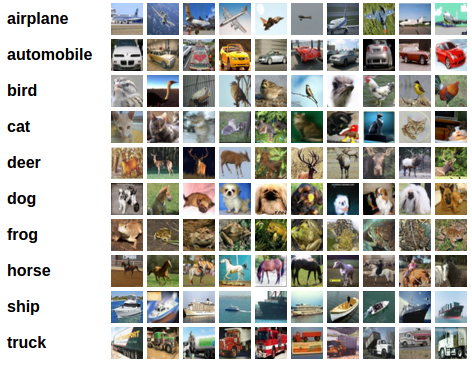

## Setup

### Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Hyper-parameters

In [3]:
batch_size = 32
num_workers = 4
num_epochs = 10
learning_rate = 0.001
momentum = 0.9

<a id='load'></a>
## 1. Load and pre-process data

- Define preprocessing algorithm
- Load training and test dataset

### 1.1 Define preprocessing algorithm

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to pytorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # normalize dataset for each channel
])

### 1.2 Load training and test dataset

In [5]:
# Download train and test dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, 
                                 download=True, transform=transform)

# Dataset sampler (shuffle, distributed loading)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=True, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                          shuffle=False, num_workers=num_workers)

print(f"num. examples: train = {len(train_dataset)}, test = {len(test_dataset)}")

Files already downloaded and verified
Files already downloaded and verified
num. examples: train = 50000, test = 10000


In [6]:
classes = np.array(['plane', 'car', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'])

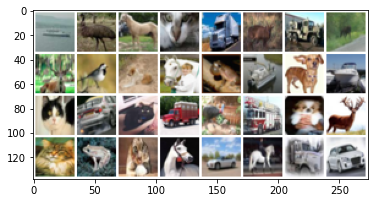

['ship' 'bird' 'horse' 'cat' 'truck' 'deer' 'truck' 'deer' 'deer' 'bird'
 'dog' 'horse' 'frog' 'ship' 'dog' 'ship' 'cat' 'car' 'cat' 'truck' 'bird'
 'truck' 'dog' 'deer' 'cat' 'frog' 'cat' 'horse' 'car' 'horse' 'truck'
 'car']


In [7]:
# Functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images, pad_value=1))
print(classes[labels])

<a id=define></a>
## 2. Define the CNN model **+ training step + loss + optimizer**

In [8]:
class Net(pl.LightningModule):
    def __init__(self, **kwargs):
        super(Net, self).__init__()
        # save hyper-parameters
        self.save_hyperparameters()
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
        # Define loss function
        self.loss = nn.CrossEntropyLoss()
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log('loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),
                               lr=self.hparams.learning_rate,
                               momentum=self.hparams.momentum)
    

In [9]:
# Construct model
model = Net(learning_rate=learning_rate, momentum=momentum)
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (loss): CrossEntropyLoss()
)


<a id=trainer></a>
## 3. Setup trainer

In [10]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=num_epochs,
)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<a id=train></a>
## 4. Train the model on **training** dataset

In [11]:
trainer.fit(model, train_loader)


  | Name  | Type             | Params
-------------------------------------------
0 | conv1 | Conv2d           | 456   
1 | pool  | MaxPool2d        | 0     
2 | conv2 | Conv2d           | 2.4 K 
3 | fc1   | Linear           | 48.1 K
4 | fc2   | Linear           | 10.2 K
5 | fc3   | Linear           | 850   
6 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params


Training: |          | 0/? [00:00<?, ?it/s]

1

In [12]:
# Show logs
!tree lightning_logs/

lightning_logs/
└── version_0
    ├── checkpoints
    │   └── epoch=9-step=15629.ckpt
    ├── events.out.tfevents.1610104166.pandora.53862.0
    └── hparams.yaml

2 directories, 3 files


<a id=analyze></a>
## 5. Assess training with tensorboard

In [14]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

Reusing TensorBoard on port 6007 (pid 46489), started 1:16:21 ago. (Use '!kill 46489' to kill it.)

<a id="validate"></a>
## 5. Test/Validate the model on **test** dataset

### 5.1 Predict using the trained model

In [ ]:
# images, labels = next(iter(test_loader))

# # predict
# prediction = model(images.to(device))
# prediction = prediction.cpu() # gpu -> cpu
# predicted_labels = torch.argmax(prediction, 1).detach()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print("Ground truth:", classes[labels])
# print("Prediction  :", classes[predicted_labels])

### 5.2. Accuracy of the model on **test** dataset

In [ ]:
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in tqdm(test_loader, total=len(test_loader)):
#         prediction = model(images.to(device)).cpu()
#         predicted_labels = torch.argmax(prediction, 1)
#         total += predicted_labels.size(0)
#         correct += (predicted_labels == labels).sum().item()

# print('Accuracy on {} test images: {}%'.format(
#     len(test_loader)*batch_size,
#      100 * correct / total))

### 5.3 Accuracy of the model per class

In [ ]:
# class_correct = np.zeros(len(classes))
# class_total = np.zeros(len(classes))
# with torch.no_grad():
#     for images, labels in tqdm(test_loader, total=len(test_loader)):
#         prediction = model(images.to(device)).cpu()
#         predicted_labels = torch.argmax(prediction, 1)
#         c = (predicted_labels == labels).squeeze()
#         for i in range(len(labels)):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1

# sorted_idx = np.argsort(class_correct/class_total)[::-1]
# for i in sorted_idx:
#     print('Accuracy of {:5s}: {}%'.format(
#            classes[i], 100 * class_correct[i] / class_total[i]))
    